# Use case: writing a binary input file for MITgcm

You may want to write binary files to create forcing data, initial condition,... for your MITgcm configuration. Here we show how xmitgcm can help.

## Simple case: a regular grid

In [1]:
import numpy as np
import xmitgcm
import matplotlib.pylab as plt

Let's build a regular lat/lon grid with one degree resolution and create a pseudo-field on this regular grid:

In [2]:
lon = np.arange(-180,180,1)
lat = np.arange(-90,90,1)

lon2, lat2 = np.meshgrid(lon,lat)

pseudo = np.cos(2*np.pi*lat2/360) * np.cos(4*np.pi*np.pi*lon2*lon2/360/360)

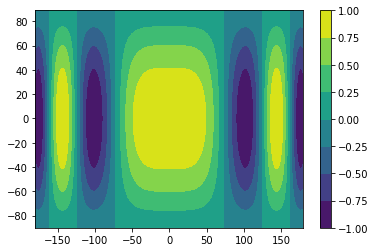

In [3]:
plt.contourf(lon2, lat2, pseudo)
plt.colorbar()

We can write the field as a binary file, to be used as an input file for the model with **xmitgcm.utils.write_to_binary**. Default is single precision, but double precision can be written with corresponding numpy.dtype. Note that here we use a numpy.array but one can use xarray as well using the *DataArray.values*

In [4]:
xmitgcm.utils.write_to_binary?

Signature: xmitgcm.utils.write_to_binary(flatdata, fileout, dtype=dtype('float32'))
Docstring:
write data in binary file

PARAMETERS:

flatdata: numpy.array
    vector of data to write
fileout: str
    output file name
dtype: np.dtype
    single/double precision
File:      ~/.conda/envs/production2/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/utils.py
Type:      function


In [5]:
xmitgcm.utils.write_to_binary(pseudo.flatten(), 'file1.bin')

## More complicated case: a LLC grid

In this case, let's assume we have a xarray dataarray or dataset well formatted on the llc grid. This dataset can be the result of a regridding onto the LLC grid that we want to use as an initial condition for the model (for example). We need to generate the binary file that MITgcm can read. Here's what we can do:

In [6]:
# First let's download a sample dataset
! wget https://ndownloader.figshare.com/files/14066567
! tar -xf 14066567

--2019-05-01 21:16:09--  https://ndownloader.figshare.com/files/14066567
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.48.232.64, 63.32.41.137, 54.229.125.140, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.48.232.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/14066567/global_oce_llc90.tar.gz [following]
--2019-05-01 21:16:09--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/14066567/global_oce_llc90.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.36.2
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.36.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84966646 (81M) [application/gzip]
Saving to: ‘14066567.1’

100%[======================================>] 84,966,646  12.9MB/s   in 6.6s   

2019-05-01 21:16:16 (12.3 MB/s) - ‘14066567.1’ saved [84966646/8496664

We can load this dataset with xmitgcm:

In [7]:
extra_metadata = xmitgcm.utils.get_extra_metadata(domain='llc', nx=90)

ds = xmitgcm.open_mdsdataset('./global_oce_llc90/', iters= [8], geometry='llc', extra_metadata=extra_metadata)

In [8]:
ds

<xarray.Dataset>
Dimensions:   (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 1)
Coordinates:
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    iter      (time) int64 8
  * time      (time) int64 8
    XC        (face, j, i) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    YC        (face, j, i)

Now let's say we want to use the temperature T and make it the initial condition for another simulation. First we need to re-build the facets, concatenate them into the compact form that MITgcm reads/writes and then write the compact to a binary file. We would do this as follows:

In [9]:
# temperature
facets = xmitgcm.utils.rebuild_llc_facets(ds['T'], extra_metadata)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', extra_metadata)
xmitgcm.utils.write_to_binary(compact, 'T_initial_condition.bin')

In this case, we already had the binary file to read from so we can compare checksums:

In [10]:
!md5sum T_initial_condition.bin

045086cc85a66aa59a713ab7d716539e  T_initial_condition.bin


In [11]:
!md5sum ./global_oce_llc90/T.0000000008.data

045086cc85a66aa59a713ab7d716539e  ./global_oce_llc90/T.0000000008.data


The file generated is identical to the original file! A similar function exist for 2d files,...